In [1]:
import geopandas as gpd
import pandas as pd
import GOSTnets as gn
import networkx as nx
import osmnx as ox
from shapely.geometry import Point
from shapely.geometry import box
import numpy as np

In [2]:
cd /home/op/network_manila

/home/op/network_manila


In [3]:
#https://epsg.io/3123
crs_manila = {'init': 'epsg:3123'}
crs_global = {'init': 'epsg:4326'}

In [4]:
G_clip = nx.read_gpickle('data_osm_raw/manila_clean_clipped.pickle')

In [81]:
G_clip_disrupted = nx.read_gpickle('data_osm_raw/manila_clean_clipped_disrupted.pickle')

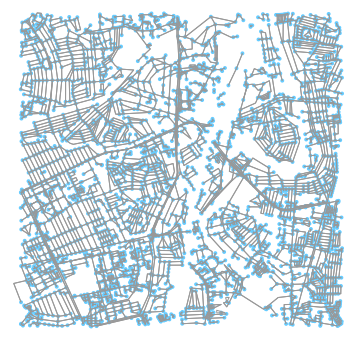

(<Figure size 440.617x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd0641385f8>)

In [60]:
ox.plot_graph(G_clip_disrupted)

In [5]:
#get administrative boundary of metro manila
philippines_adm2 = gpd.read_file("boundaries/philippines_adm2.geojson")
philippines_adm2 = philippines_adm2.to_crs({'init':'epsg:4326'})
manila = philippines_adm2[philippines_adm2.ADM2_NAME=="Metropolitan Manila"]

In [6]:
manila = manila.to_crs(crs_manila)

In [7]:
def create_point_grid(gdf, distance, crs):
    """
    this function creates a grid of points with equal distance within the space described by the geodataframe
    important: the crs passed as param has to be in accordance with the distance specified
    :param gdf: a geodataframe
    :param distance: distance between points. measured in crs of gdf
    :param crs: the crs in which the distance is measured to return the points
    :returns: a geodataframe of points
    """

    gdf_copy = gdf.copy()
    gdf_copy = gdf_copy.to_crs(crs)
    minx, miny, maxx, maxy = gdf_copy.bounds.values[0]
    poly = gdf_copy.unary_union
    x = minx
    points = []
    while x < maxx:
        y = miny
        while y < maxy:
            point = Point(x,y)
            #check whether point is within poly and keep only if this is the case
            if poly.intersects(point):
                points.append(point)
            y = y + distance
        x = x + distance
    df = pd.DataFrame({'geometry':points})  
    points_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=crs)
    return points_gdf

In [8]:
origin_points = create_point_grid(manila, distance = 2000, crs = crs_manila)

In [9]:
box_geom = box(121.05, 14.6, 121.1, 14.65)
df = pd.DataFrame({"geometry":box_geom}, index=[0])
box_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=crs_global)

In [82]:
#clipped area only
origin_points = create_point_grid(box_gdf, distance = 500, crs = crs_manila)

In [83]:
origin_points = origin_points.to_crs(crs_global)
manila = manila.to_crs(crs_global)

In [84]:
hospitals = gpd.read_file(r"asset_data/MetroManila/MetroManila/DOH/HealthFacilities.shp")
hospitals = hospitals[hospitals.intersects(box_gdf.unary_union)]

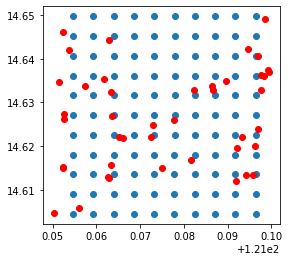

In [85]:
ax = origin_points.plot()
hospitals.plot(ax = ax, color='red')

In [40]:
origins_snapped = gn.pandana_snap(G_clip, 
                                  origin_points, 
                                  source_crs='epsg:4326',
                                  target_crs='epsg:3123', 
                                  add_dist_to_node_col = True)




/home/op/anaconda3/envs/network_manila/lib/python3.6/site-packages/GOSTnets-0.1.2-py3.6.egg/GOSTnets/core.py:1605: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/op/anaconda3/envs/network_manila/lib/python3.6/site-packages/GOSTnets-0.1.2-py3.6.egg/GOSTnets/core.py:1607: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [41]:
hospitals_snapped = gn.pandana_snap(G_clip, 
                                  hospitals, 
                                  source_crs='epsg:4326',
                                  target_crs='epsg:3123', 
                                  add_dist_to_node_col = True)




In [43]:
origin_nodes = list(origins_snapped.NN)
hospital_nodes = list(hospitals_snapped.NN)

In [44]:
len(origin_nodes), len(hospital_nodes)

(110, 43)

In [86]:
origins_snapped_disrupted = gn.pandana_snap(G_clip_disrupted, 
                                  origin_points, 
                                  source_crs='epsg:4326',
                                  target_crs='epsg:3123', 
                                  add_dist_to_node_col = True)




/home/op/anaconda3/envs/network_manila/lib/python3.6/site-packages/GOSTnets-0.1.2-py3.6.egg/GOSTnets/core.py:1605: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/op/anaconda3/envs/network_manila/lib/python3.6/site-packages/GOSTnets-0.1.2-py3.6.egg/GOSTnets/core.py:1607: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [87]:
hospitals_snapped_disrupted = gn.pandana_snap(G_clip_disrupted, 
                                  hospitals, 
                                  source_crs='epsg:4326',
                                  target_crs='epsg:3123', 
                                  add_dist_to_node_col = True)




In [88]:
origin_nodes_disrupted = list(origins_snapped_disrupted.NN)
hospital_nodes_disrupted = list(hospitals_snapped_disrupted.NN)

In [64]:
OD = gn.calculate_OD(G_clip, origins= origin_nodes, destinations = hospital_nodes, 
                  fail_value = 1000000, weight = 'time', weighted_origins = False)
#in seconds

In [89]:
OD_disrupted = gn.calculate_OD(G_clip_disrupted, origins= origin_nodes_disrupted, 
                               destinations = hospital_nodes_disrupted, 
                               fail_value = 1000000, weight = 'time', weighted_origins = False)
#in seconds

In [66]:
OD.shape , OD_disrupted.shape

((110, 43), (110, 43))

In [90]:
min_distance = np.min(OD, axis = 1)
min_distance_disrupted = np.min(OD_disrupted, axis = 1)

len(min_distance)

110

In [91]:
min_distance_disrupted[min_distance_disrupted > 100000] = np.NaN

In [95]:
origin_points['min_hospital_distance_seconds'] = min_distance
origin_points['min_hospital_distance_seconds_disrupted'] = min_distance_disrupted

origin_points.head()

,geometry,min_hospital_distance_seconds,min_hospital_distance_seconds_disrupted
0,POINT (121.05463 14.60452),20.585416,20.585416
1,POINT (121.05463 14.60904),114.184579,114.184579
2,POINT (121.05463 14.61356),66.596817,66.596817
3,POINT (121.05463 14.61808),68.669157,68.669157
4,POINT (121.05464 14.62259),56.751145,56.751145


In [96]:
origin_points

,geometry,min_hospital_distance_seconds,min_hospital_distance_seconds_disrupted
0,POINT (121.05463 14.60452),20.585416,20.585416
1,POINT (121.05463 14.60904),114.184579,114.184579
2,POINT (121.05463 14.61356),66.596817,66.596817
3,POINT (121.05463 14.61808),68.669157,68.669157
4,POINT (121.05464 14.62259),56.751145,56.751145
...,...,...,...
105,POINT (121.09641 14.63162),50.268065,22.500000
106,POINT (121.09641 14.63614),36.745631,22.500000
107,POINT (121.09641 14.64066),17.603840,4.500000
108,POINT (121.09642 14.64518),43.720239,31.500000


In [ ]:
something is wrong here... 

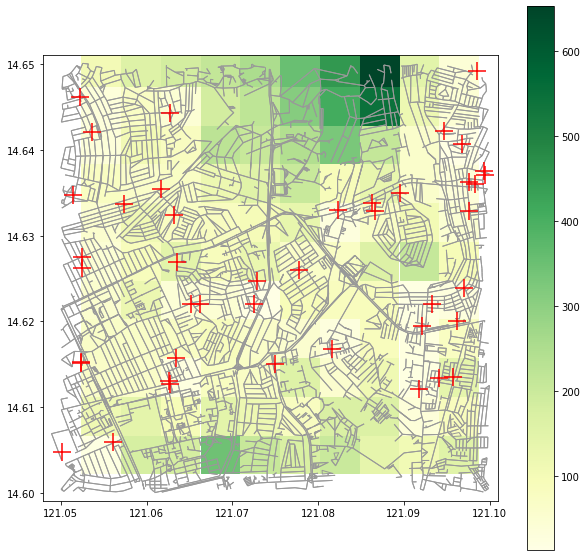

<Figure size 432x288 with 0 Axes>

In [77]:
G_clip.graph.update( {'crs' : crs_global} )
G_clip.graph.update( {'name' : 'manila'} )
fig, ax = ox.plot_graph(G_clip, fig_height=10, axis_off=False, show=False, node_color="None" )
origin_points.plot(ax=ax, cmap="YlGn", column="min_hospital_distance_seconds", 
                   marker = "s", markersize=1500, zorder=-1, legend=True)
hospitals.plot(ax = ax, color="red", marker="+", markersize=300, zorder=2)
fig

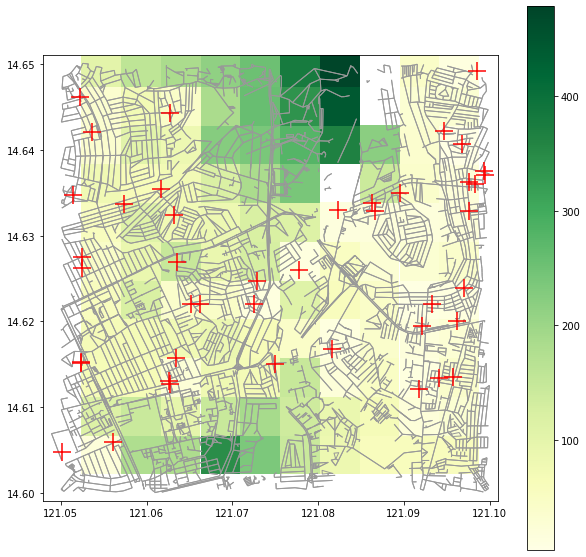

<Figure size 432x288 with 0 Axes>

In [94]:
G_clip_disrupted.graph.update( {'crs' : crs_global} )
G_clip_disrupted.graph.update( {'name' : 'manila'} )
fig1, ax = ox.plot_graph(G_clip_disrupted, fig_height=10, axis_off=False, show=False, node_color="None" )
origin_points.plot(ax=ax, cmap="YlGn", column="min_hospital_distance_seconds_disrupted", 
                   marker = "s", markersize=1500, zorder=-1, legend=True)
hospitals.plot(ax = ax, color="red", marker="+", markersize=300, zorder=2)
fig1